In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
from lightgbm import plot_tree
from graphviz import Digraph
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import time
import pickle

%matplotlib inline

# Load Original Features

In [40]:
feat_num = 469

In [42]:
#df_total_raw = pd.read_csv('./data/features%s.csv'%(feat_num))
with open('./data/features%s.pickle'%(feat_num), 'rb') as handle:
    df_total_raw = pickle.load(handle)

In [44]:
#to_drop = ['card1_count','addr2','V117','V118','V120','V122','id_25','id_21','id_26',
#           'V305','id_17','V27','V28','V88','V89','id_14','V107','V240','V241','V41','id_24','V68']
#to_drop = ['C8']
to_drop = ['V'+str(i) for i in range(1,340)]
#with open('./data/feat%s_rm_pm_importance0.pickle'%(feat_num), 'rb') as handle:
#    to_drop = pickle.load(handle)

In [45]:
df_total = df_total_raw.drop(to_drop,axis=1)
#df_total = df_total_raw

In [47]:
features_train = df_total[df_total['isFraud'].notnull()]
features_test = df_total[df_total['isFraud'].isnull()]

In [48]:
labels_train = features_train['isFraud']
features_train = features_train.drop(columns = ['isFraud', 'TransactionID'])

In [49]:
features_train.shape

(590540, 128)

# Prepare model

In [50]:
categorical = ['ProductCD', 'card2', 'card3', 'card4', 'card5','card6',
              'addr1','addr2','P_email','R_email','M1','M2','M3',
              'M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo','dow','hour',
              'Device_name','Device_version','screen_width','screen_height',
               'P_email_suffix','R_email_suffix','id_30_OS','id_30_version',
              'is_card_freq_Device','is_wide','is_long','is_zero','is_win8_vista',
              'is_windows_otheros','is_card_freq_pdc','is_card_freq_addr1'] 
ids = [ 'id_%s'%(i) for i in range(12,39)]
categorical = categorical + ids

In [51]:
categorical = list(set(categorical).intersection(df_total.columns))

In [52]:
features_test_new = features_test.drop(columns = ['isFraud', 'TransactionID'])

In [59]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,#0.006883242363721497,
          "boosting_type":"gbdt",#'goss'
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'num_threads':10
          #'device' :'gpu',
          #'is_unbalance':True
          #'scale_pos_weight':9
         }

# Feature Selection

In [57]:
features_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,card_D15_mean,card_D15_std,addr1_D15_mean,addr1_D15_std,TransactionAmt_decimal,Device_name,Device_version,is_card_freq_Device,screen_width,screen_height
0,86400,68.5,0,13926,NaN,150.0,0,142.0,0,315.0,...,0.000000,0.000000,0.000000,0.000000,500,-1,-1,False,-1,-1
1,86401,29.0,0,2755,404.0,150.0,1,102.0,0,325.0,...,0.000000,0.000000,0.000000,0.000000,0,-1,-1,False,-1,-1
2,86469,59.0,0,4663,490.0,150.0,2,166.0,1,330.0,...,2.188598,1.578656,1.420777,1.251501,0,-1,-1,False,-1,-1
3,86499,50.0,0,18132,567.0,150.0,1,117.0,1,476.0,...,0.471748,0.434842,0.581165,0.474049,0,-1,-1,False,-1,-1
4,86506,50.0,1,4497,514.0,150.0,1,102.0,0,420.0,...,NaN,NaN,NaN,NaN,0,0,0,False,0,0


In [58]:
start = time.time()
train_set = lgb.Dataset(features_train.iloc[0:472432,:], label=labels_train.values[0:472432],categorical_feature=categorical)#
valid_set = lgb.Dataset(features_train.iloc[472432:,:], label=labels_train.values[472432:],categorical_feature=categorical)#
valid_results = {}
model = lgb.train(params,train_set,num_boost_round = 10000, 
                  valid_sets = [train_set, valid_set],
                  verbose_eval=500,
                  early_stopping_rounds = 500,
                  evals_result=valid_results)
print(time.time()-start)

/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.950776	valid_1's auc: 0.894625
[1000]	training's auc: 0.969063	valid_1's auc: 0.902935
[1500]	training's auc: 0.977606	valid_1's auc: 0.907369
[2000]	training's auc: 0.983347	valid_1's auc: 0.910496
[2500]	training's auc: 0.987252	valid_1's auc: 0.912116
[3000]	training's auc: 0.989875	valid_1's auc: 0.913708
[3500]	training's auc: 0.992007	valid_1's auc: 0.914837
[4000]	training's auc: 0.993642	valid_1's auc: 0.915565
[4500]	training's auc: 0.994863	valid_1's auc: 0.915824
[5000]	training's auc: 0.995912	valid_1's auc: 0.916127
[5500]	training's auc: 0.996694	valid_1's auc: 0.916493
[6000]	training's auc: 0.99729	valid_1's auc: 0.916238
Early stopping, best iteration is:
[5530]	training's auc: 0.996731	valid_1's auc: 0.916553
562.5454025268555


In [53]:
max(valid_results['valid_1']['auc'])

0.9176377503540559

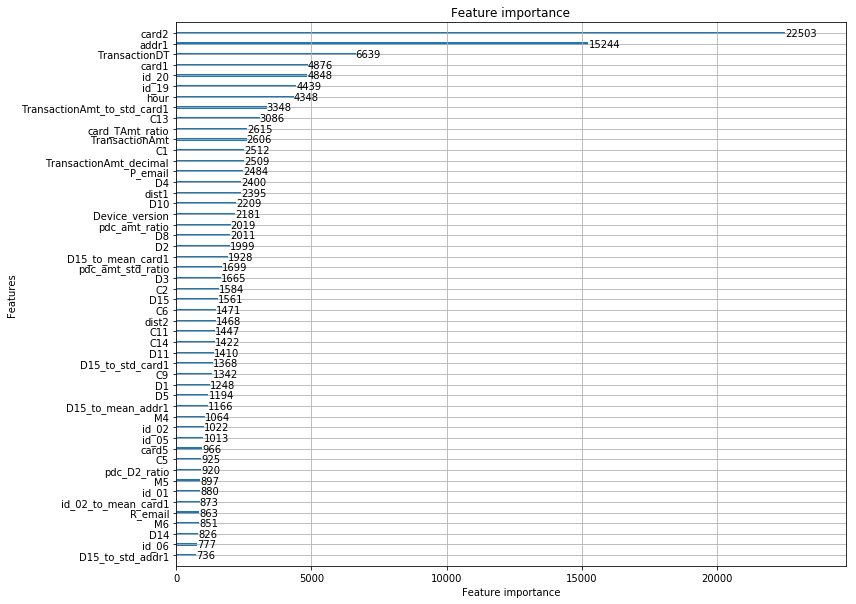

In [54]:
lgb.plot_importance(model, max_num_features=50,figsize=(12,10))

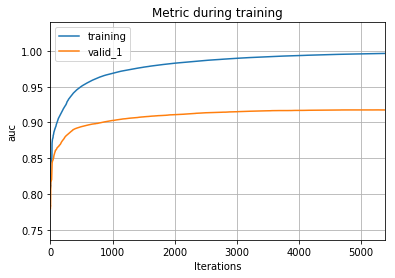

In [55]:
#lgb.plot_split_value_histogram(model, feature='dist1', bins='auto')
lgb.plot_metric(valid_results, metric='auc')

In [ ]:
lgb.plot_tree(model,tree_index=0, figsize=(107,105))

In [29]:
graph = lgb.create_tree_digraph(model, tree_index=0, name='Tree0')
graph.render(view=True)

'Tree0.gv.pdf'

# Train Model

In [60]:
splits = 5
folds = KFold(n_splits = splits,random_state=50)
predictions = np.zeros(len(features_test_new))
ave_auc = 0

In [61]:
for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, 
                                                          labels_train.values)):
    print("Fold {}".format(fold_num))
    train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
    valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]
    
    trn_data = lgb.Dataset(train_df, label=y_train_df,categorical_feature=categorical)
    val_data = lgb.Dataset(valid_df, label=y_valid_df,categorical_feature=categorical)
    
    valid_results = {}
    clf = lgb.train(params,
                    trn_data,
                    10000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=500,
                   evals_result=valid_results)
    
    pred = clf.predict(valid_df)
    auc_score = roc_auc_score(y_valid_df, pred)
    ave_auc += auc_score / splits
    predictions += clf.predict(features_test_new) / splits

Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.994086	valid_1's auc: 0.910114
[1000]	training's auc: 0.999708	valid_1's auc: 0.917336
[1500]	training's auc: 0.999994	valid_1's auc: 0.918163
[2000]	training's auc: 1	valid_1's auc: 0.91918
[2500]	training's auc: 1	valid_1's auc: 0.91957
[3000]	training's auc: 1	valid_1's auc: 0.919605
Early stopping, best iteration is:
[2679]	training's auc: 1	valid_1's auc: 0.919568
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.994844	valid_1's auc: 0.93086
[1000]	training's auc: 0.999801	valid_1's auc: 0.93346
Early stopping, best iteration is:
[985]	training's auc: 0.999778	valid_1's auc: 0.933549
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.995117	valid_1's auc: 0.928121
[1000]	training's auc: 0.999798	valid_1's auc: 0.929383
Early stopping, best iteration is:
[789]	training's auc: 0.999123	valid_1's auc: 0.929727
Fold 3


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.994906	valid_1's auc: 0.947276
[1000]	training's auc: 0.999798	valid_1's auc: 0.95037
[1500]	training's auc: 0.999997	valid_1's auc: 0.950543
Early stopping, best iteration is:
[1174]	training's auc: 0.999949	valid_1's auc: 0.950609
Fold 4


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.994673	valid_1's auc: 0.922363
[1000]	training's auc: 0.999791	valid_1's auc: 0.925257
[1500]	training's auc: 0.999997	valid_1's auc: 0.925846
[2000]	training's auc: 1	valid_1's auc: 0.926258
[2500]	training's auc: 1	valid_1's auc: 0.926259
Early stopping, best iteration is:
[2282]	training's auc: 1	valid_1's auc: 0.926412


In [64]:
for col in features_train.columns:
    print(col)

TransactionDT
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_01
id_02
id_03
id_04
id_05
id_06
id_07
id_08
id_09
id_10
id_11
id_12
id_13
id_14
id_15
id_16
id_17
id_18
id_19
id_20
id_21
id_22
id_23
id_24
id_25
id_26
id_27
id_28
id_29
id_31
id_32
id_34
id_35
id_36
id_37
id_38
DeviceType
P_email
P_email_suffix
R_email
R_email_suffix
id_30_OS
id_30_version
dow
hour
pdc_amt_ratio
pdc_amt_std_ratio
pdc_D1_ratio
pdc_D2_ratio
pdc_D1_std_ratio
pdc_D2_std_ratio
card_TAmt_ratio
TransactionAmt_to_std_card1
is_card_freq_pdc
is_card_freq_addr1
pdc_D3_std_ratio
pdc_D3_ratio
card_D1_mean
card_D2_mean
card_D3_mean
card_D1_std
card_D2_std
card_D3_std
card1_count
id_02_to_mean_card1
card_id_02_mean
card_id_02_std
card_D15_mean
card_D15_std
addr1_D15_mean
addr1_D15_std
TransactionAmt_decimal
Device_name
Device_version
is_card_freq_Device
scree

In [62]:
ave_auc

0.9319730729043392

In [31]:
# feat457 drop Vfeature
ave_auc

0.9320555176749314

In [16]:
# feat 457 drop c8
ave_auc

0.9354828335082059

In [19]:
# feat 457 all features
ave_auc

0.9352800271384787

In [44]:
###### drop using feat476_rm_pm_importance0
ave_auc

0.9352034490404105

In [32]:
id_test = features_test['TransactionID']
submission = pd.DataFrame({'TransactionID': id_test, 
                            'isFraud': predictions})
submission.to_csv('./data/sub_feat%s_rm_v.csv'%(feat_num), index = False)